In [13]:
import pandas as pd
import numpy as np
import yfinance as yf
import seaborn as sns
import matplotlib.pyplot as plt
from prophet import Prophet
import datetime as dt
from datetime import date
import tkinter.messagebox as mbox



import time
from selenium import webdriver
from bs4 import BeautifulSoup
from urllib.parse import urljoin

import warnings
warnings.filterwarnings("ignore")

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

# Environment settings: 
pd.set_option('display.max_column', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_seq_items', None)
pd.set_option('display.max_colwidth', 500)
pd.set_option('expand_frame_repr', True)

In [14]:
def get_page(url):
    """Download a webpage and return a beautiful soup doc"""
    ##### Web scrapper for infinite scrolling page #####
    driver = webdriver.Chrome(executable_path=r"E:\Chromedriver\chromedriver_win32_chrome83\chromedriver.exe")
    driver.get(url)
    time.sleep(2)  # Allow 2 seconds for the web page to open
    scroll_pause_time = 1 # You can set your own pause time. My laptop is a bit slow so I use 1 sec
    screen_height = driver.execute_script("return window.screen.height;")   # get the screen height of the web
    i = 1

    while True:
        # scroll one screen height each time
        driver.execute_script("window.scrollTo(0, {screen_height}*{i});".format(screen_height=screen_height, i=i))  
        i += 1
        time.sleep(scroll_pause_time)
        # update scroll height each time after scrolled, as the scroll height can change after we scrolled the page
        scroll_height = driver.execute_script("return document.body.scrollHeight;")  
        # Break the loop when the height we need to scroll to is larger than the total scroll height
        if i == 20:
            break 

    ##### Extract Reddit URLs #####
    soup = BeautifulSoup(driver.page_source, "html.parser")
    return soup

In [15]:
def get_news_tags(doc):
    """Get the list of tags containing news information"""
    news_class = "Ov(h) Pend(44px) Pstart(25px)" ## class name of div tag 
    news_list  = doc.find_all('div', {'class': news_class})
    return news_list

In [16]:
def parse_news(news_tag):
    """Get the news data point and return dictionary"""
    news_source = news_tag.find_all('span')[0].text #source
    news_time = news_tag.find_all('span')[1].text #link
    news_headline = news_tag.find('a').text #heading
    news_content = news_tag.find('p').text #content
    news_image = news_tag.findParent().find('img')['src'] #thumb image
    return { 'source' : news_source,
            'time' : news_time,    
            'headline' : news_headline,
            'content' : news_content,
           }

In [17]:
def scrape_yahoo_news(url, path=None):
    """Get the yahoo finance market news and write them to CSV file """
    if path is None:
        path = 'stock-market-news.csv'
        
    #print('Requesting html page')
    doc = get_page(url)

    #print('Extracting news tags')
    news_list = get_news_tags(doc)

    #print('Parsing news tags')
    news_data = [parse_news(news_tag) for news_tag in news_list]

    #print('Save the data to a CSV')
    news_df = pd.DataFrame(news_data)
    #news_df.to_csv(path, index=None)
    
    #This return statement is optional, we are doing this just analyze the final output 
    return news_df 

# Entire Stock Market News

In [18]:
from datetime import datetime

now = datetime.now()
current_time = now.strftime("%H:%M:%S")
print("Report Date = ", date.today())
print("Report Time =", current_time)
YAHOO_NEWS_URL = 'https://finance.yahoo.com/topic/stock-market-news/'
news_df = scrape_yahoo_news(YAHOO_NEWS_URL)

Report Date =  2023-04-11
Report Time = 23:10:42


In [19]:
from transformers import pipeline

import warnings
warnings.filterwarnings("ignore")

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

In [20]:
sentiment_pipeline = pipeline("sentiment-analysis", model="distilbert-base-uncased-finetuned-sst-2-english")

In [21]:
sentiment = [None] * len(news_df)
sentiment_score = [None] * len(news_df)
index = -1
for sentence in news_df['headline']:
    index+=1
    result = sentiment_pipeline(sentence[:512])[0]
    sentiment[index] = result['label']
    sentiment_score[index] = result['score']
news_df['Sentiment'] = sentiment
news_df['Score'] = sentiment_score


sentiment = [None] * len(news_df)
sentiment_score = [None] * len(news_df)
index = -1
for sentence in news_df['content']:
    index+=1
    result = sentiment_pipeline(sentence[:512])[0]
    sentiment[index] = result['label']
    sentiment_score[index] = result['score']
news_df['Sentiment2'] = sentiment
news_df['Score2'] = sentiment_score

In [22]:
news_df[news_df['Score'] > 0.8];

<AxesSubplot:xlabel='Sentiment', ylabel='Count'>

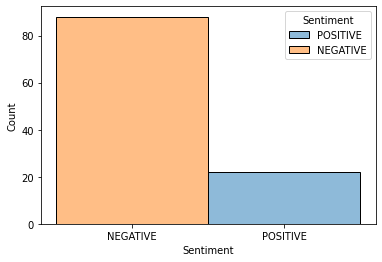

In [23]:
sns.histplot(x = 'Sentiment', data = news_df[news_df['Score'] > 0.8], hue = 'Sentiment', hue_order=['POSITIVE', 'NEGATIVE'])

<AxesSubplot:xlabel='Sentiment2', ylabel='Count'>

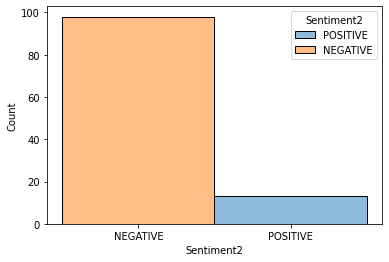

In [24]:
sns.histplot(x = 'Sentiment2', data = news_df[news_df['Score2'] > 0.8], hue = 'Sentiment2', hue_order=['POSITIVE', 'NEGATIVE'])

In [25]:
import sys
sys.path.insert(1, 'C:/Users/Woon/Desktop/Columbia/Applied Analytics/Term3/Sentiment_SNP')

import helper_functions
from helper_functions import *

In [26]:
from collections import defaultdict
from plotly import tools
import plotly.offline as py
py.init_notebook_mode(connected=True)

# Headline

In [27]:
## Get the bar chart from 5 rated reviews ##
freq_dict = defaultdict(int)
for sent in news_df["headline"]:
    for word in generate_ngrams(sent,3):
        freq_dict[word] += 1
fd_sorted = pd.DataFrame(sorted(freq_dict.items(), key=lambda x: x[1])[::-1])
fd_sorted.columns = ["word", "wordcount"]
trace0 = horizontal_bar_chart(fd_sorted.head(10), 'green')

# Creating two subplots
fig = tools.make_subplots(rows=1, cols=1, vertical_spacing=0.04,
                          subplot_titles=["Frequent words"])
fig.append_trace(trace0, 1, 1)
#fig.append_trace(trace1, 1, 2)
fig['layout'].update(height=600, width=600, paper_bgcolor='rgb(233,233,233)', title="Word Count Plots")
py.iplot(fig, filename='word-plots');

c:\Users\Woon\AppData\Local\Programs\Python\Python310\lib\site-packages\plotly\tools.py:460: DeprecationWarning:

plotly.tools.make_subplots is deprecated, please use plotly.subplots.make_subplots instead



## Content

In [28]:
## Get the bar chart from 5 rated reviews ##
freq_dict = defaultdict(int)
for sent in news_df["content"]:
    for word in generate_ngrams(sent,3):
        freq_dict[word] += 1
fd_sorted = pd.DataFrame(sorted(freq_dict.items(), key=lambda x: x[1])[::-1])
fd_sorted.columns = ["word", "wordcount"]
trace0 = horizontal_bar_chart(fd_sorted.head(10), 'green')

# Creating two subplots
fig = tools.make_subplots(rows=1, cols=1, vertical_spacing=0.04,
                          subplot_titles=["Frequent words"])
fig.append_trace(trace0, 1, 1)
#fig.append_trace(trace1, 1, 2)
fig['layout'].update(height=600, width=600, paper_bgcolor='rgb(233,233,233)', title="Word Count Plots")
py.iplot(fig, filename='word-plots');

c:\Users\Woon\AppData\Local\Programs\Python\Python310\lib\site-packages\plotly\tools.py:460: DeprecationWarning:

plotly.tools.make_subplots is deprecated, please use plotly.subplots.make_subplots instead



# Ticker

In [29]:
from urllib.request import Request, urlopen
from urllib.error import HTTPError
import socket
import urllib

In [30]:
url = "https://finviz.com/quote.ashx?t=SPY&ty=c&ta=1&p=d"


headers = {"User-Agent": "Mozilla/5.0"}
cookies = {"CONSENT": "YES+cb.20210720-07-p0.en+FX+410"}

req = Request(url, headers=headers)

try:
    contents = urlopen(req).read() 
    soup = BeautifulSoup(contents, features="html.parser")

    sentence2 = []

    for tag in soup.find_all('a'):

        sentence = tag.text.split(".")
        sentence2.append(sentence)

except urllib.error.HTTPError as err:
    print(err.code)

except socket.timeout as se:
    print("socket timeout")

In [31]:
df = pd.DataFrame(sentence2)

In [32]:
df['Headline'] = df[0]
df['Sentiment'] = -2
df = pd.DataFrame(list(zip(df['Headline'], df['Sentiment'])), columns=['Headline', 'Sentiment'])

In [33]:
i = []

for string in df['Headline']:
    i.append(count_words(string))

df['word_count'] = i

In [34]:
sentiment = [None] * len(df)
sentiment_score = [None] * len(df)
index = -1
for sentence in df['Headline']:
    index+=1
    result = sentiment_pipeline(sentence[:512])[0]
    sentiment[index] = result['label']
    sentiment_score[index] = result['score']
df['Sentiment'] = sentiment
df['Score'] = sentiment_score

In [35]:
df = df[df['word_count'] > 10]
df['Headline_Lower'] = df['Headline'].str.lower()

In [36]:
df[df['Score'] > 0.8];

<AxesSubplot:xlabel='Sentiment', ylabel='Count'>

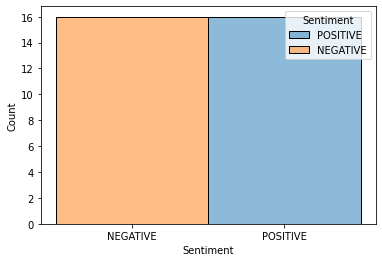

In [37]:
sns.histplot(x = 'Sentiment', data = df[df['Score'] > 0.8], hue = 'Sentiment', hue_order=['POSITIVE', 'NEGATIVE'])

In [38]:
text_input = input("Type in the Ticker: ")
#message = text_input
#mbox.showinfo("The Ticker You've Entered:", message)
print("You entered:", text_input)

You entered: SPY


In [39]:
spy_ohlc_df = yf.download(text_input, start=dt.date.today() - dt.timedelta(days=1095), end=dt.date.today())
df=spy_ohlc_df.reset_index()

[*********************100%***********************]  1 of 1 completed


<AxesSubplot:xlabel='Date', ylabel='Close'>

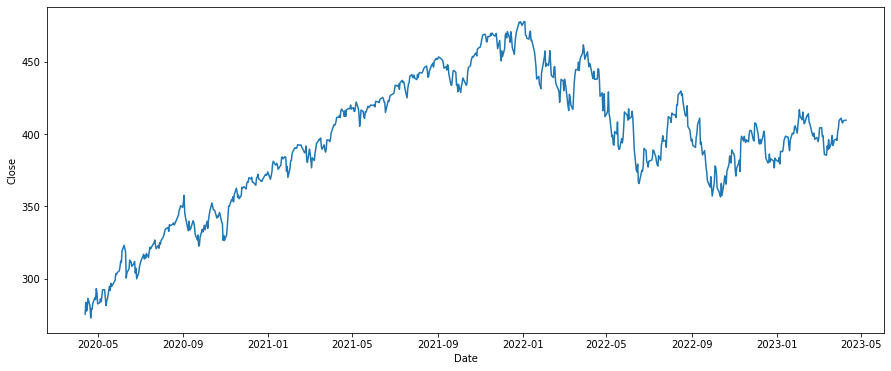

In [40]:
fig, ax = plt.subplots()
fig.set_size_inches(15,6)
sns.lineplot(x = 'Date', y = 'Close', data = df)
plt.show()

In [41]:
# Load SPY price data
spy_data = df
spy_data = df[['Date', 'Close']]
spy_data.columns = ['ds', 'y']

# Initialize Prophet model
model = Prophet()

# Fit the model on SPY data
model.fit(spy_data)

# Create future dates for forecasting
future_dates = model.make_future_dataframe(periods=3)

# Make predictions for future dates
forecast = model.predict(future_dates)

23:11:47 - cmdstanpy - INFO - Chain [1] start processing
23:11:47 - cmdstanpy - INFO - Chain [1] done processing


Text(0.5, 1.0, 'Forecasted Price')

Text(0.5, 33.0, 'dt')

Text(60.125, 0.5, 'Price')

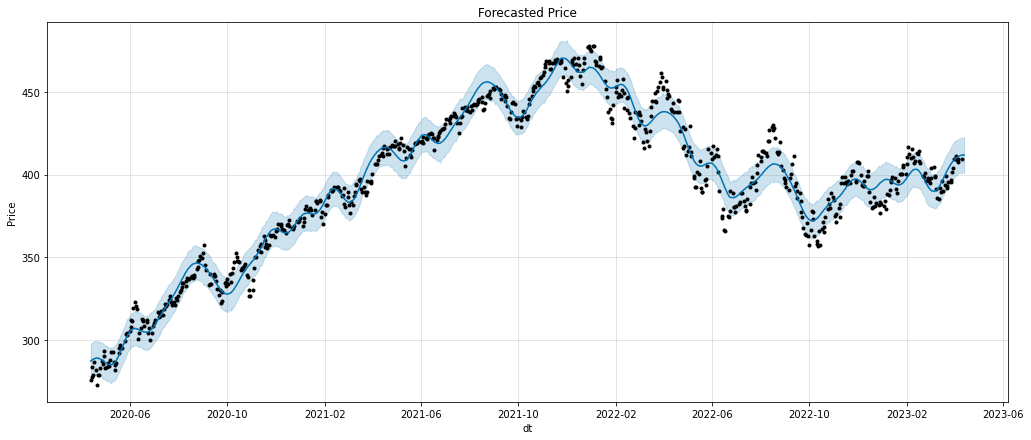

In [42]:
fig = model.plot(forecast, xlabel='Date', ylabel='SPY Price')
fig.set_size_inches(15,6)
plt.title('Forecasted Price')
plt.xlabel('dt')
plt.ylabel('Price')
plt.show()

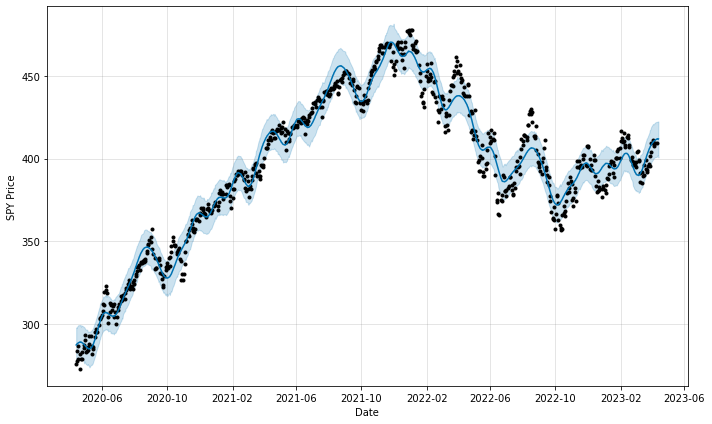

(19451.0, 19461.0)

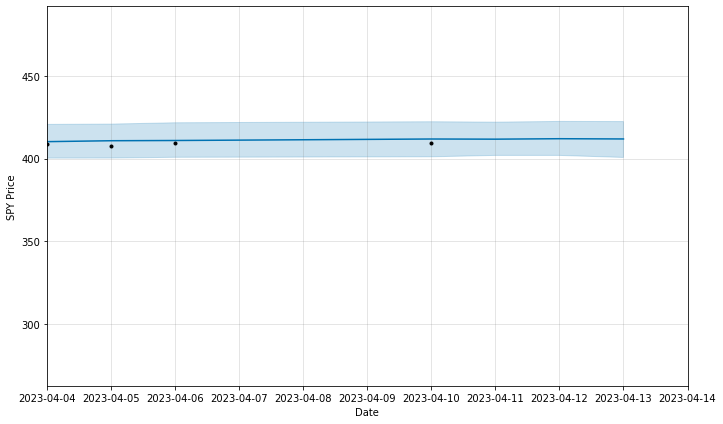

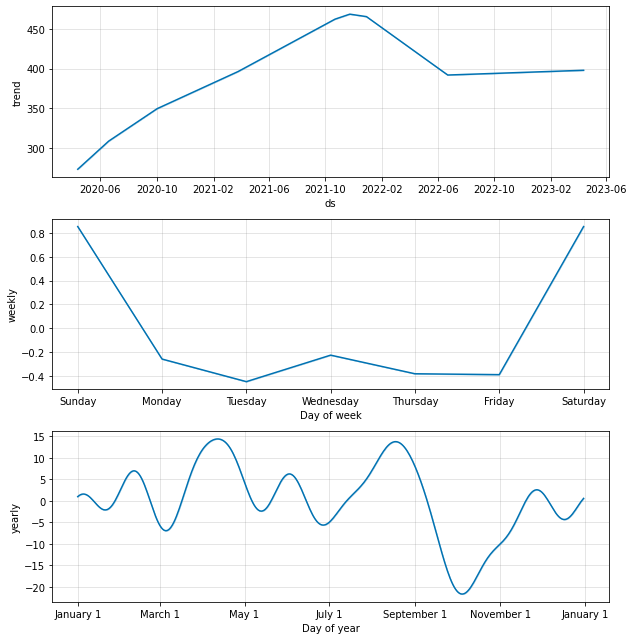

In [43]:
# Plot the forecasted data
model.plot(forecast, xlabel='Date', ylabel='SPY Price')
plt.xlim(dt.date.today() - dt.timedelta(days=7), dt.date.today() + dt.timedelta(days=3))

# Plot the forecasted trend and seasonality components
fig = model.plot_components(forecast)
plt.show()

In [44]:
spy_ohlc_df = yf.download(text_input, start=dt.date.today() - dt.timedelta(days=7), end=dt.date.today(), interval='1m')
df1=spy_ohlc_df.reset_index()

[*********************100%***********************]  1 of 1 completed


<AxesSubplot:xlabel='Datetime', ylabel='Close'>

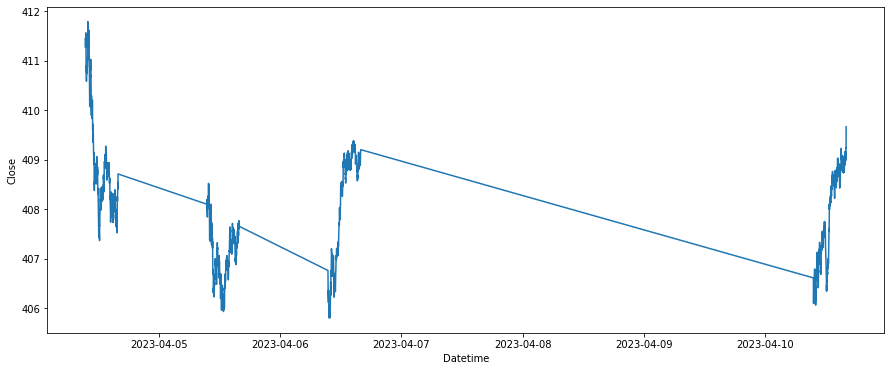

In [46]:
fig, ax = plt.subplots()
fig.set_size_inches(15,6)
sns.lineplot(x = 'Datetime', y = 'Close', data = df1)
plt.show()

In [48]:
# Load SPY price data
spy_data = df1
spy_data = df1[['Datetime', 'Close']]
spy_data.columns = ['ds', 'y']

# Initialize Prophet model
model = Prophet()

# Fit the model on SPY data
model.fit(spy_data)

# Create future dates for forecasting
future_dates = model.make_future_dataframe(periods=2880, freq='T')

# Make predictions for future dates
forecast = model.predict(future_dates)


23:12:43 - cmdstanpy - INFO - Chain [1] start processing
23:12:44 - cmdstanpy - INFO - Chain [1] done processing


Text(0.5, 1.0, 'Forecasted Price')

Text(0.5, 33.0, 'dt')

Text(60.125, 0.5, 'Price')

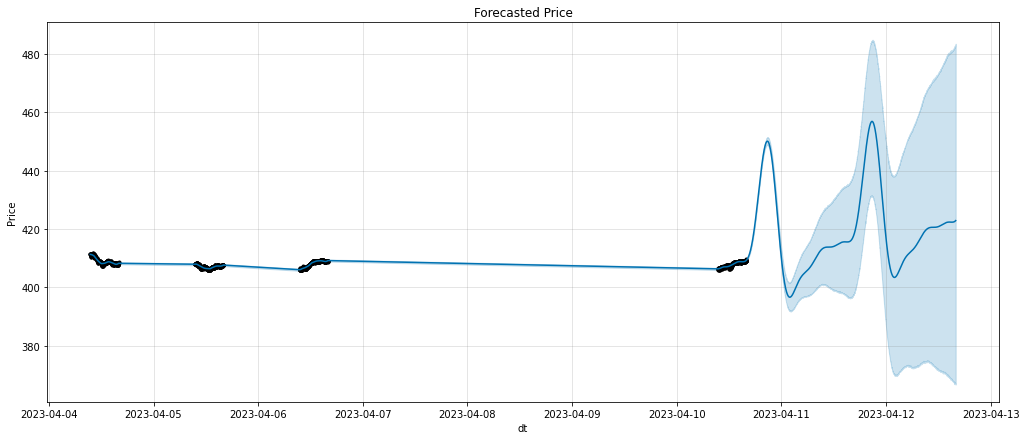

In [49]:
fig = model.plot(forecast, xlabel='Date', ylabel='SPY Price')
fig.set_size_inches(15,6)
plt.title('Forecasted Price')
plt.xlabel('dt')
plt.ylabel('Price')
plt.show()

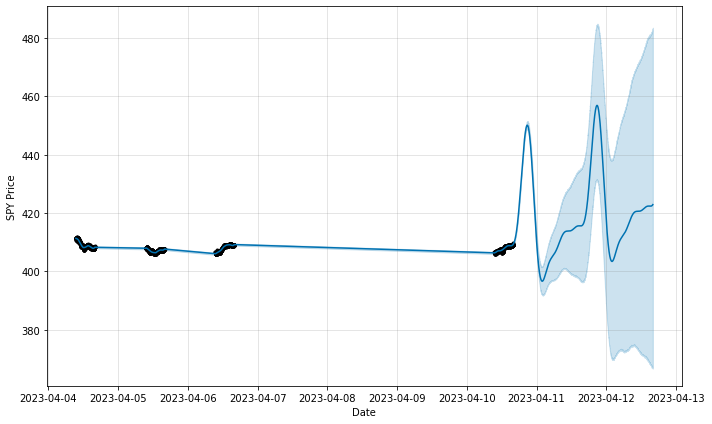

(19457.0, 19460.0)

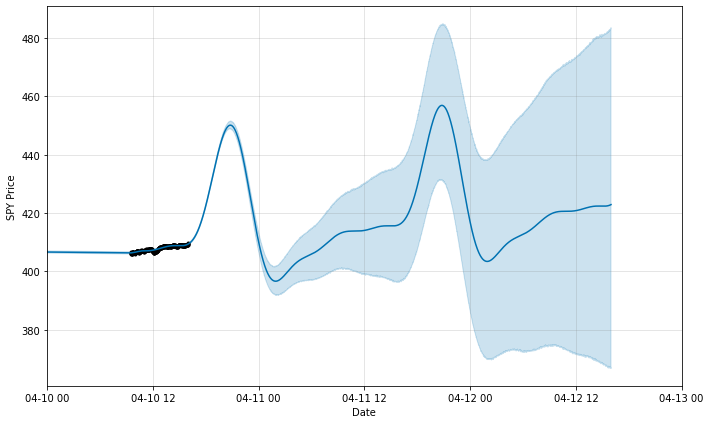

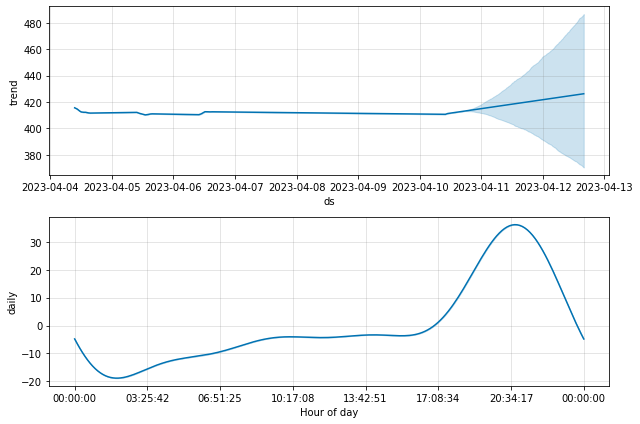

In [50]:
# Plot the forecasted data
model.plot(forecast, xlabel='Date', ylabel='SPY Price')
plt.xlim(dt.date.today() - dt.timedelta(days=1), dt.date.today() + dt.timedelta(minutes=2880))

# Plot the forecasted trend and seasonality components
fig = model.plot_components(forecast)
plt.show()